***Semantička segmentacija na skupu podataka CamVid***
--
----
**Model**: 

Predtrenirani resnet18 uz maknuti average pool i potpuno povezani sloj te uz dodani konvolucijski sloj (veličina filtera 1x1). Također je napravljeno bilinearno naduzorkovanje nad izlaznim logitima na početnu veličinu, dakle veličinu ulaza.

**Optimizator**: 
  * ADAM uz defaultne parametre

**Funkcija gubtika**:
  * Cross Entropy Loss

**Metrika**: 
   + P = (Ukupan broj točno klasificiranih piksela) / (ukupni broj piksela)

**Skup podataka**:
*   Train - 367 slika, veličina 960x720 piksela, smanjeno na 480x360 piksela
*   Valid - 101 slika, veličina 960x720 piksela, smanjeno na 480x360 piksela
*   Test - 233 slika, veličina 960x720 piksela, smanjeno na 480x360 piksela
*   Labele - crno bijele, oznacene po ids, 0-11 što odgovara id-u klase
*   Klase:
      * CamVid se sastoji od sljedećih 11 klasa:
      * ("Building", (128, 0, 0)),
      * ("Tree", (128, 128, 0)), 
      * ("Sky", (128, 128, 128)),  
      * ("Car", (64, 0, 128)),   
      * ("SignSymbol", (192, 128, 128)), 
      * ("Road", (128, 64, 128)), 
      * ("Pedestrian", (64, 64, 0)),  
      * ("Fence", (64, 64, 128)),  
      * ("Column_Pole", (192, 192, 128)),
      * ("Sidewalk", (0, 0, 192)),
      * ("Bicyclist", (0, 128, 192)),
      * ("Void", (0, 0, 0)) kao dodatna klasa koja oznacava sve ostalo


**Ostali parametri**:
  * Batch size: 16
  * Broj epoha: 80
  * Vrijeme potrebno za svaku epohu: 17 sekundi


**Zaključak**: 

  * Izgleda da mreža uči i daje dobre rezultate, nije 100% točnost, ali mogu se sa slike raspoznati cjeline, odnosno klase.
  * Rezultati točnosti:
      * Treniranje - 94%
      * Validacija - 90%
      * Testiranje - 85%


Izradila: Jelena Bratulić, 16.4.2020.

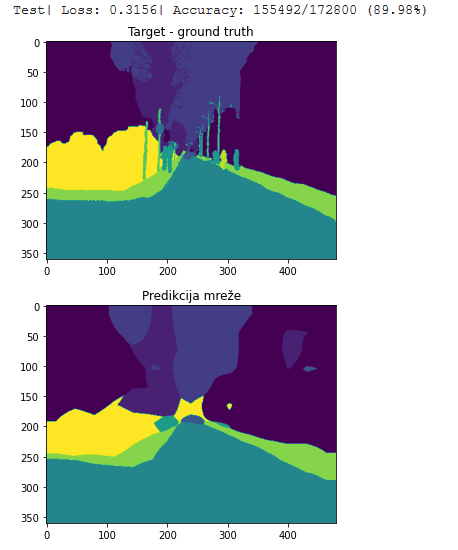



In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

"\nfrom google.colab import drive\ndrive.mount('/content/drive/')\n"

In [ ]:
!unzip '/content/drive/My Drive/CamVid/train_camvid.zip'
!unzip '/content/drive/My Drive/CamVid/val_camvid.zip'
!unzip '/content/drive/My Drive/CamVid/test_camvid.zip'
!unzip '/content/drive/My Drive/CamVid/labels_cv.zip'

"\n!unzip '/content/drive/My Drive/CamVid/train_camvid.zip'\n!unzip '/content/drive/My Drive/CamVid/val_camvid.zip'\n!unzip '/content/drive/My Drive/CamVid/test_camvid.zip'\n!unzip '/content/drive/My Drive/CamVid/labels_cv.zip'\n"

In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import numpy as np
import math
import glob
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from collections import OrderedDict
from skimage.transform import resize
import matplotlib.image as mimg
from matplotlib import cm

#from .utils import load_state_dict_from_url


try:
  from torch.hub import load_state_dict_from_url
except ImportError:
  from torch.utils.model_zoo import load_url as load_state_dict_from_url

In [ ]:
camvid_colors = OrderedDict([
("Building", (128, 0, 0)),    #0
("Tree", (128, 128, 0)),   #1
("Sky", (128, 128, 128)),  #2
("Car", (64, 0, 128)),    #3
("SignSymbol", (192, 128, 128)),  #4
("Road", (128, 64, 128)),  #5
("Pedestrian", (64, 64, 0)),  #6
("Fence", (64, 64, 128)),   #7
("Column_Pole", (192, 192, 128)),  #8
("Sidewalk", (0, 0, 192)),   #9
("Bicyclist", (0, 128, 192)), #10
("Void", (0, 0, 0))]) #11

color_info = [(128, 0, 0), (128, 128, 0), (128, 128, 128), (64, 0, 128), (192, 128, 128), (128, 64, 128), (64, 64, 0),
              (64, 74, 128), (192, 192, 128), (0, 0, 192), (0, 128, 192), (0, 0, 0)]

In [ ]:
__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}

In [ ]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


In [ ]:
def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


In [ ]:
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(
                                 replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, 
                               padding=3,bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        # self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.conv2 = nn.Conv2d(512, 12, kernel_size=1, stride=1, 
                               bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        B, C, H, W = x.shape
        x0 = self.conv1(x)
        x0 = self.bn1(x0)
        x0 = self.relu(x0)
        x0 = self.maxpool(x0) #f0 izlaz

        x1 = self.layer1(x0)  # f1 izlaz
        x2 = self.layer2(x1)  #f2 izlaz
        x3 = self.layer3(x2) # logiti na  predikciji /16 #f3 izlaz
        x4 = self.layer4(x3)  #f4 izlaz
        x5 = self.conv2(x4)
        
        x5 = torch.nn.functional.interpolate(x5, size=(H,W), mode='bilinear')
        
        return x5

    def forward(self, x):
        return self._forward_impl(x)

In [ ]:
def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
      state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
      model.load_state_dict(state_dict, strict=False)
        
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained=pretrained, progress=progress,
                   **kwargs)


In [ ]:
class CamVidDataset(Dataset):
    """CamVid dataset for semantic segmentation."""
    mean = [111.376, 63.110, 83.670]
    std = [41.608, 54.237, 68.889]

    mean1=[0.485, 0.456, 0.406]
    std1=[0.229, 0.224, 0.225]
    
    def __init__(self, im_root, label_root):
        self.images = list(sorted(glob.glob(im_root+'*.png')))
        self.labels = list(sorted(glob.glob(label_root+'*.png')))

        self.resize1 = transforms.Resize((360,480))
        self.resize2 = transforms.Resize((360,480), interpolation=Image.NEAREST)
        self.normalize = transforms.Normalize(self.mean1, self.std1)
        self.tenzoriraj = transforms.ToTensor()

    def transforms(self, image, target):
        
        image = self.resize1(image)
        image = self.tenzoriraj(image)
        image = self.normalize(image)

        target = self.resize2(target)
        target = np.array(target)
        target = torch.tensor(target) #stvoren na ovaj način kako ga automatski ne bi prebacio 0-1
      
        return image, target

    

    def __len__(self):
        return len(self.images)

    def __getitem__(self, item):
        image = Image.open(self.images[item])
        label= Image.open(self.labels[item])
        return self.transforms(image, label)

In [ ]:
train_root = 'train/'
train_labels_root = 'train_labels/'
valid_root = 'val/'
valid_labels_root = 'valid_labels/'
test_root = 'test/'
test_labels_root = 'test_labels/'

device = torch.device('cuda')
epochs = 80
batch_size = 16

In [ ]:
dataset_train = CamVidDataset(im_root=train_root, label_root=train_labels_root)
train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=2)

dataset_valid = CamVidDataset(im_root=valid_root, label_root=valid_labels_root)
valid_loader = DataLoader(dataset=dataset_valid, batch_size=batch_size, shuffle=True, num_workers=2)

dataset_test = CamVidDataset(im_root=test_root, label_root=test_labels_root)
test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
network = resnet18(pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters())
#optimizer = optim.SGD(params=network.parameters(), lr=0.001, momentum=0.9)
network.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def train(epoch):
    network.train()
    index = 0
    total_train = 0
    correct = 0
    total = len(train_loader.dataset)*480*360
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        target = target.squeeze(1)
        target = target.type(torch.cuda.LongTensor)
        optimizer.zero_grad()
        output = network(data)
        # import pdb; pdb.set_trace()
        pred = torch.argmax(output.data, dim=1)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        correct += pred.eq(target.data.view_as(pred)).sum()

    print('Train| Epoch {}| Loss: {:.6f}| Accuracy: {:.6f}%'.format(
          epoch,loss.item(), 
          100. * correct / total))

In [ ]:
def valid(epoch):
    network.eval()
    test_loss = 0
    correct = 0
    ukupno = len(valid_loader.dataset)*480*360
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            target = target.squeeze(1)
            target = target.type(torch.cuda.LongTensor)
            output = network(data)
            test_loss += criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(valid_loader.dataset)
    print('Valid| Epoch {}|Avg. loss: {:.4f}| Accuracy: {:.2f}%'.format(epoch,
    test_loss, 100.*correct / ukupno))

In [ ]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    ukupno = len(test_loader.dataset)*480*360
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            target = target.squeeze(1)
            target = target.type(torch.cuda.LongTensor)
            output = network(data)
            test_loss += criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    print('Tests| Avg. loss: {:.4f}| Accuracy: {:.2f}%)'.format(
    test_loss, 100.*correct / ukupno))

In [ ]:
for epoch in range(1, epochs + 1):
    time0 = time.time()
    train(epoch)
    valid(epoch)
    print("Running time for Epoch {}: {} s\n".format(epoch, (time.time() - time0)))

In [ ]:
test()